<a href="https://colab.research.google.com/github/AlekseevaTatiana23/Python_Libraries_for_DS/blob/main/ht6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%ls


diabetes-dataset.csv  sample_data/


Урок 6. Определение проблемы переобучения на практике
Ваша задача — построить модель машинного обучения для предсказания целевой переменной на примере датасета ирисы Фишера. В процессе выполнения задания вы должны применить концепции переобучения и недообучения, кросс-валидации, регуляризации (L1 и L2), а также оценить способность вашей модели к обобщению.

1. Предварительная обработка данных.
Загрузите данные и проведите их первичный анализ. Очистите данные, если это необходимо, и проведите их нормализацию/стандартизацию.
Разделите данные на тренировочный и тестовый наборы.

2. Обучение модели.
— Обучите модель логистической регрессии без регуляризации. Оцените её качество на тренировочных и тестовых данных.
— Повторите шаг с добавлением L1- и L2-регуляризации. Подберите оптимальные значения параметра регуляризации с помощью кросс-валидации.

3. Анализ результатов.
— Сравните качество всех трёх моделей (без регуляризации, с L1- и с L2-регуляризацией). Как влияют L1 и L2 на качество модели по сравнению с базовой моделью?
— Постройте графики кривых обучения для каждой из моделей. Что вы можете сказать о способности ваших моделей к обобщению?

4. Отчёт.
— Подготовьте краткий отчёт, в котором обоснуйте свой выбор параметров для моделей с регуляризацией, объясните полученные результаты и сделайте выводы о качестве моделирования.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import time

In [4]:
# Загрузка датасета ирисов Фишера
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

# Первичный анализ
print(X.head())


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


Датасет Ирисы Фишера является классическим набором данных, используемым для задач классификации в машинном обучении. Он содержит информацию о трех видах ирисов и включает четыре измеряемых характеристики.

Описание столбцов датасета

Sepal Length (см): длина чашелистика (наружной доли околоцветника) в сантиметрах
Sepal Width (см): ширина чашелистика в сантиметрах
Petal Length (см): длина лепестка (внутренней доли околоцветника) в сантиметрах
Petal Width (см): ширина лепестка в сантиметрах
Species: вид ириса, к которому принадлежит образец (Iris setosa, Iris versicolor, Iris virginica)

In [5]:
print(X.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB
None


In [7]:
print(y.value_counts())



0    50
1    50
2    50
Name: count, dtype: int64


In [8]:
# Проверка на пропуски
print(X.isnull().sum())

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64


In [9]:
print(X.describe())

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  


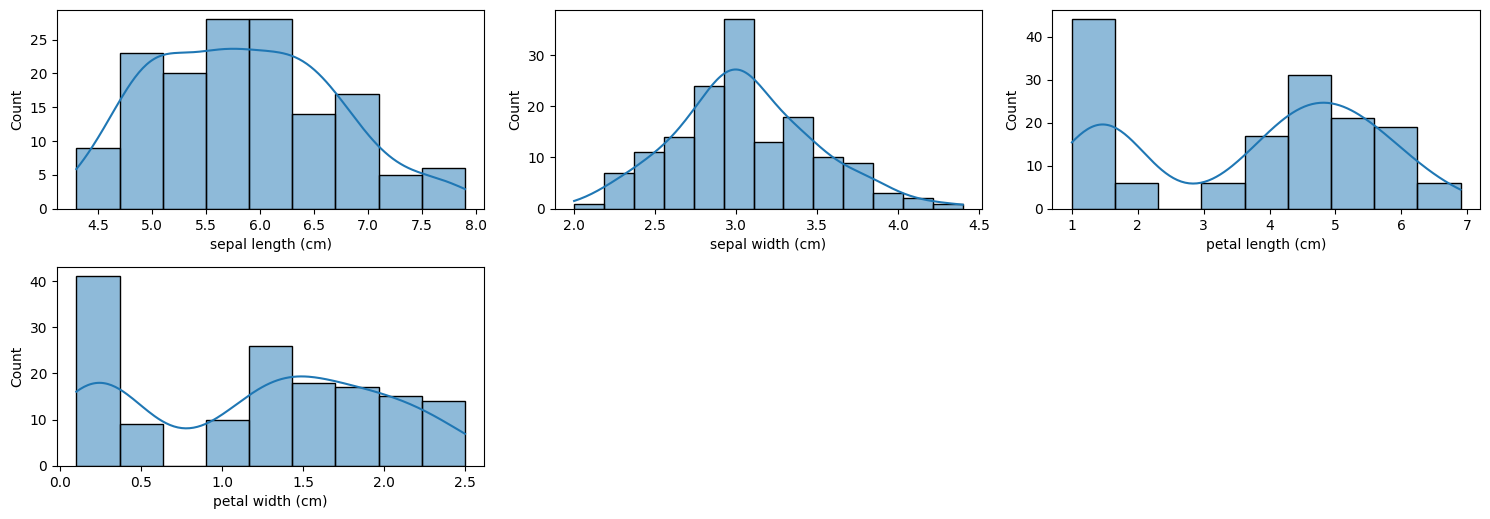

In [12]:
# Визуализация гистограмм
plt.figure(figsize=(15, 10))
for i, column in enumerate(X.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(X[column], kde=True)

plt.tight_layout()
plt.show()

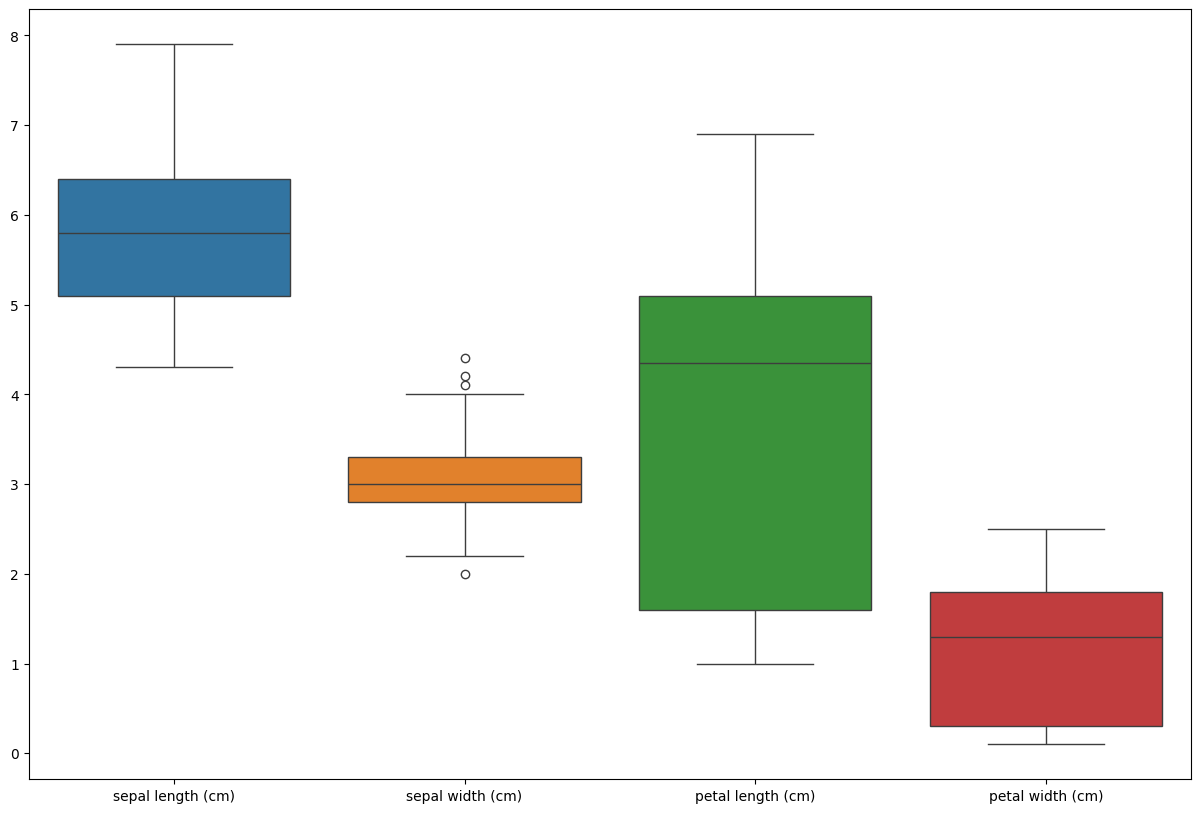

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=X, ax=ax)
plt.show()

Стандартизируем наши данные и раздели на обучающую и тестовую выборки
Для алгоритмов, чувствительных к масштабу (например, логистическая регрессия с регуляризацией), рекомендуется стандартизация.

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
X_train.shape, X_test.shape

((120, 4), (30, 4))

1. Обучение модели лог.регрессии без регуляризации

In [19]:
# Создание и обучение модели логистической регрессии
lg = LogisticRegression(class_weight='balanced', max_iter=200)
lg.fit(X_scaled, y)


# После обучения модели можно получить коэффициенты\
lg.coef_

array([[-1.07659238,  1.15977648, -1.92814138, -1.81227307],
       [ 0.5899243 , -0.36263595, -0.36461312, -0.82700241],
       [ 0.48666809, -0.79714052,  2.2927545 ,  2.63927548]])

In [20]:
feature_names = X.columns
coefficients = lg.coef_  # lg.coef_ возвращает массив в массиве, если модель обучена на двухмерном X

# Связывание имен признаков с их коэффициентами
feature_importances = zip(feature_names, coefficients)

# Преобразование в список для более удобного отображения
feature_importance_list = list(feature_importances)

# Отображение признаков и их коэффициентов
for feature, coef in feature_importance_list:
    print(f"{feature}: {coef}")

sepal length (cm): [-1.07659238  1.15977648 -1.92814138 -1.81227307]
sepal width (cm): [ 0.5899243  -0.36263595 -0.36461312 -0.82700241]
petal length (cm): [ 0.48666809 -0.79714052  2.2927545   2.63927548]


Коэффициенты для каждого класса: модель логистической регрессии обучается на три класса (в данном случае три вида ирисов). Каждый класс имеет свой набор коэффициентов, которые показывают, как каждый признак влияет на вероятность принадлежности к этому классу.

Значение коэффициентов:

Положительные коэффициенты: увеличивают вероятность принадлежности к классу. Если признак увеличивается, то вероятность принадлежности к этому классу также увеличивается.
Отрицательные коэффициенты: уменьшают вероятность принадлежности к классу. Если признак увеличивается, то вероятность принадлежности к этому классу уменьшается.

In [23]:
accuracy_test = accuracy_score(y_test, lg.predict(X_test))

accuracy_train = accuracy_score(y_train, lg.predict(X_train))


print("Логистическая регрессия:")
print("Тренировочный accuracy:", accuracy_train)
print("Тестовый accuracy:", accuracy_test)

Логистическая регрессия:
Тренировочный accuracy: 0.975
Тестовый accuracy: 0.9666666666666667


### Основные наблюдения

- **Тренировочная точность (accuracy):** 0.975  
  Это означает, что модель правильно классифицировала около 97.5% обучающих примеров. Очень высокая точность указывает на хорошую подгонку к обучающим данным.

- **Тестовая точность (accuracy):** 0.967 (приблизительно)  
  На тестовых данных модель показывает точность около 96.7%, что очень близко к тренировочной точности. Это свидетельствует о хорошей способности модели к обобщению и отсутствии значительного переобучения.

### Итог
Модель логистической регрессии показала высокую точность как на обучающей, так и на тестовой выборках, что указывает на хорошую обобщающую способность и сбалансированную модель без явных признаков недообучения или переобучения.


In [25]:
# Отчет о классификации
from sklearn.metrics import classification_report
y_pred = lg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Подбор оптимального значения параметра L1- и L2-регуляризации с помощью кросс-валидации

In [27]:
from sklearn.model_selection import GridSearchCV
# Определение модели логистической регрессии с L1 регуляризацией
model = LogisticRegression(penalty='l1', solver='liblinear')

# Определение диапазона значений параметра регуляризации C для поиска
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Настройка кросс-валидации с GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, # 5-кратная кросс-валидация
                           scoring='accuracy')

# Обучение модели на обучающих данных с кросс-валидацией
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и соответствующей точности
print("Лучшее значение C для L1 регуляризации:", grid_search.best_params_['C'])
print("Лучшая точность на кросс-валидации:", grid_search.best_score_)

# Оценка модели на тестовом наборе данных с лучшим значением C
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Точность на тестовом наборе:", test_accuracy)

Лучшее значение C для L1 регуляризации: 10
Лучшая точность на кросс-валидации: 0.9583333333333334
Точность на тестовом наборе: 0.9333333333333333


In [28]:
# Определение модели логистической регрессии с L1 регуляризацией
model = LogisticRegression(penalty='l2')

# Определение диапазона значений параметра регуляризации C для поиска
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Настройка кросс-валидации с GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Обучение модели на обучающих данных с кросс-валидацией
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и соответствующей точности
print("Лучшее значение C для L2 регуляризации:", grid_search.best_params_['C'])
print("Лучшая точность на кросс-валидации:", grid_search.best_score_)

# Оценка модели на тестовом наборе данных с лучшим значением C
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Точность на тестовом наборе:", test_accuracy)

Лучшее значение C для L2 регуляризации: 10
Лучшая точность на кросс-валидации: 0.9666666666666668
Точность на тестовом наборе: 1.0


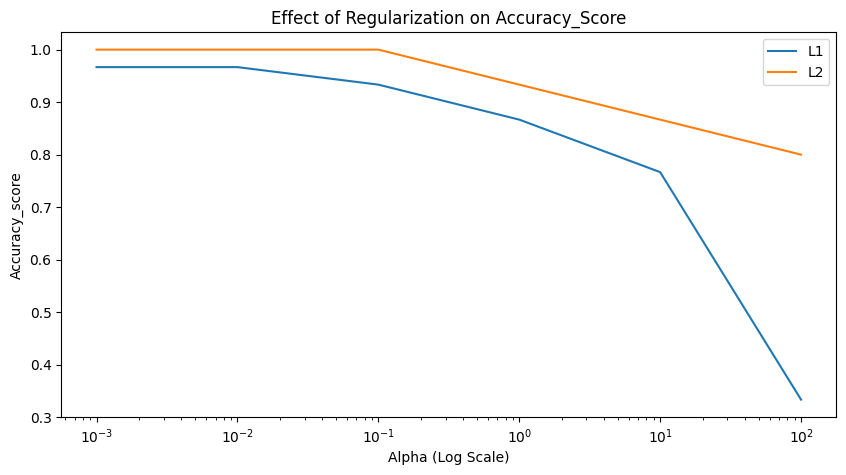

In [29]:
import matplotlib.pyplot as plt

# Переопределим данные для создания графиков
accuracy_score_l1 = []
accuracy_score_l2 = []

# Тестируем Lasso регрессию и Ridge регрессию, сохраняем результаты R^2
alphas = [0.001, 0.01, 0.1, 1, 10, 100] # регулировки степени регуляризации (чем меньше alpha, тем слабее регуляризация, и наоборот).
for alpha in alphas:
    # Логистическая регрессия с L1 регуляризацией
    logistic_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=1/alpha)  # 'liblinear' поддерживает L1 #C=1/alpha, так как C — это обратная величина регуляризации
    logistic_l1.fit(X_train, y_train)
    y_pred_l1 = logistic_l1.predict(X_test)
    accuracy_score_l1.append(accuracy_score(y_test, y_pred_l1))

for alpha in alphas:
    # Логистическая регрессия с L2 регуляризацией
    logistic_l2 = LogisticRegression(penalty='l2', C=1/alpha)  # По умолчанию 'l2'
    logistic_l2.fit(X_train, y_train)
    y_pred_l2 = logistic_l2.predict(X_test)

    accuracy_score_l2.append(accuracy_score(y_test, y_pred_l2))

# Создаем графики
plt.figure(figsize=(10, 5))
plt.plot(alphas, accuracy_score_l1, label='L1')
plt.plot(alphas, accuracy_score_l2, label='L2')
plt.xscale('log')
plt.xlabel('Alpha (Log Scale)')
plt.ylabel('Accuracy_score')
plt.title('Effect of Regularization on Accuracy_Score')
plt.legend()
plt.show()

Построение графиков кривых обучения для каждой из моделей

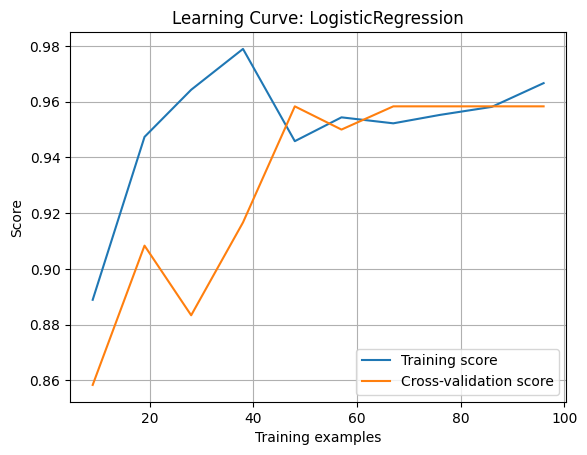

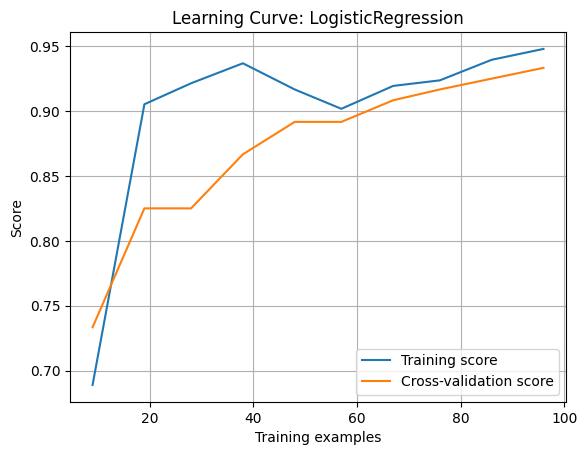

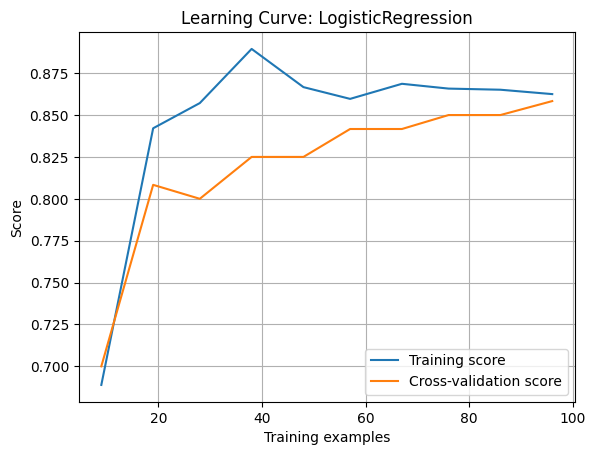

In [32]:
from sklearn.model_selection import learning_curve #для построения кривых обучения


# Определение моделей
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Logistic Regression with L1': LogisticRegression(penalty='l1', solver='liblinear', C=1, max_iter=200),
    'Logistic Regression with L2': LogisticRegression(penalty='l2', solver='liblinear', C=1/10, max_iter=200)
}

# Функция для построения кривых обучения
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5
    )

    # Средние значения точности для обучающей и тестовой выборок
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    # Построение графика
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curve: {model.__class__.__name__}')
    plt.legend()
    plt.grid()
    plt.show()

# Построение кривых обучения для каждой модели
for model_name, model in models.items():
    plot_learning_curve(model, X_train, y_train)

Интерпретация графиков

Обучающая кривая: показывает производительность модели на обучающих данных. Если эта кривая высока и стабильно растет с увеличением размера обучающей выборки, это хороший признак, однако в нашем случае только модель на тестовых данных без регуляции показывает более-менее стабильный результат с увеличением количества обучающих данных, модели же с регуляцией показали падение, что может говорить о том, что модели с регуляцией склонны к переобучению. Падение на обучающей кривой может также быть связано с неправильной настройкой гиперпараметров модели, таких как скорость обучения или регуляризация. Если скорость обучения слишком высока, это может привести к нестабильному поведению модели во время обучения.
Кросс-валидационная кривая: показывает производительность модели на валидационных данных. Если эта кривая значительно ниже обучающей или не растет с увеличением размера выборки, это может указывать на переобучение или недообучение. В нашем случае все модели показали устойчивый рост, несмотря на незначительные снижения точности для моделей с регуляцией для количества тестовых данных между значениями 30 и 40.
Разница между кривыми: если разница между обучающей и тестовой кривыми велика (например, обучающая кривая высока и тестовая низка), это может свидетельствовать о переобучении. В нашем случае кривые у всех моделей с увеличением количества тестовых данных сближаются.